<a href="https://colab.research.google.com/github/ansehoon1999/pytorch_practice/blob/main/pytorch_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

if torch.cuda.is_available() :
  DEVICE = torch.device('cuda')
else :
  DEVICE = torch.device('cpu')
print('Using pytorch version: ', torch.__version__, ' Device: ', DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

Using pytorch version:  1.10.0+cu111  Device:  cpu


In [ ]:
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = False,
                                      transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


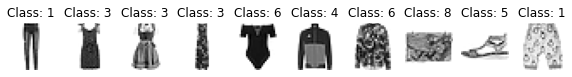

In [ ]:
for (X_train, y_train) in train_loader :
  print('X_train: ', X_train.size(), 'type: ', X_train.type())
  print('y_train: ', y_train.size(), 'type: ', y_train.type())
  break

pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10) :
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
class AE(nn.Module) :
  def __init__(self) :
    super(AE, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),)
    
    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28 * 28),)
    
  def forward(self, x) :
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded



In [ ]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [ ]:
def evaluate(model, test_loader) :
  model.eval()
  test_loss = 0
  real_image = []
  gen_image = []

  with torch.no_grad() :
    for image, _ in test_loader :
      image = image.view(-1, 28 * 28).to(DEVICE)
      target = image.view(-1, 28 * 28).to(DEIVCE)
      encoded, decoded = model(image)

      test_loss += criterion(decoded, image).item()
      real_image.append(image.to("cpu"))
      gen_image.append(decoded.to("cpu"))
  
  test_loss /= (len(test_loader.dataset) / BATCH_SIZE) 

  return test_loss, real_image, gen_image
   

In [ ]:
for epoch in range(1, EPOCHS + 1) :
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, real_image, gen_image = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(epoch, test_loss))
  f, a = plt.subplot(2, 10, figsize = (10, 4))
  for i in range(10) :
    img = np.reshape(real_image[0][i], (28, 28))
    a[0][i].imshow(img, cmap = "gray_r")
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())
  for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
  
  plt.show()


Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.014458
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.017279
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.012101
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.013556
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.015531
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.011098
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.012993
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.013606
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.016185
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.013272


NameError: ignored